In [6]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import random
from collections import deque
import matplotlib.dates as mdates
import joblib

# ---------------------------------------------------
# 1. Setup logging
# ---------------------------------------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
logger = logging.getLogger(__name__)

# ---------------------------------------------------
# 2. Environment definition
# ---------------------------------------------------
class UnsupervisedStageEnv(gym.Env):
    def __init__(self, features, prices):
        super().__init__()
        self.features = features
        self.prices = prices
        self.n = len(prices)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf,
                                                 shape=(features.shape[1],), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(5)
        self.reset()

    def reset(self):
        self.i = 0
        return self.features[self.i]

    def step(self, action):
        position_map = {0: 0.0, 1: 1.0, 2: 0.0, 3: -1.0, 4: 0.0}
        pos = position_map[action]
        raw_ret = (self.prices[self.i + 1] - self.prices[self.i]) / self.prices[self.i]
        reward = pos * raw_ret

        self.i += 1
        done = (self.i >= self.n - 1)
        obs = None if done else self.features[self.i]
        return obs, reward, done, {}

# ---------------------------------------------------
# 3. DQN Model
# ---------------------------------------------------
class DQN(nn.Module):
    def __init__(self, in_dim, out_dim=5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim)
        )

    def forward(self, x):
        return self.net(x)

# ---------------------------------------------------
# 4. Replay Buffer
# ---------------------------------------------------
class ReplayBuffer:
    def __init__(self, capacity=10_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return map(np.array, zip(*batch))

    def __len__(self):
        return len(self.buffer)

# ---------------------------------------------------
# 5. DQN Training
# ---------------------------------------------------
def train_unsupervised_dqn_multi(envs, episodes=50, batch_size=32, gamma=0.99, lr=1e-3):
    device = torch.device('cpu')
    obs_dim = envs[0].observation_space.shape[0]
    act_dim = envs[0].action_space.n

    policy_net = DQN(obs_dim, act_dim).to(device)
    target_net = DQN(obs_dim, act_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    buffer = ReplayBuffer()
    eps_decay = lambda f: 0.01 + (1.0 - 0.01) * np.exp(-f / 500)

    frame_count = 0
    for ep in range(episodes):
        for env in envs:
            state = env.reset()
            done = False
            while not done:
                eps = eps_decay(frame_count)
                frame_count += 1

                if random.random() < eps:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        s_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                        q_vals = policy_net(s_t)
                        action = q_vals.argmax().item()

                next_state, reward, done, _ = env.step(action)
                buffer.push((state, action, reward, next_state if next_state is not None else state, done))
                state = next_state

                if len(buffer) >= batch_size:
                    ss, aa, rr, ns, dd = buffer.sample(batch_size)
                    ss = torch.tensor(ss, dtype=torch.float32)
                    aa = torch.tensor(aa, dtype=torch.int64)
                    rr = torch.tensor(rr, dtype=torch.float32)
                    ns = torch.tensor(ns, dtype=torch.float32)
                    dd = torch.tensor(dd, dtype=torch.float32)

                    q_values = policy_net(ss).gather(1, aa.unsqueeze(1)).squeeze()
                    with torch.no_grad():
                        next_qvals = target_net(ns).max(1)[0]
                    targets = rr + gamma * next_qvals * (1 - dd)

                    loss = nn.MSELoss()(q_values, targets)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

        if ep % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())
            logger.info(f"Episode {ep} complete")
    return policy_net

# ---------------------------------------------------
# 6. Generate Trading Signals
# ---------------------------------------------------
def generate_trading_signal_from_stage(stages):
    signals = ["HOLD"]
    for i in range(1, len(stages)):
        cur, prev = stages[i], stages[i - 1]
        if cur == 2 and prev != 2: signals.append("BUY")
        elif prev == 2 and cur != 2: signals.append("EXIT_BUY")
        elif cur == 4 and prev != 4: signals.append("SHORT_SELL")
        elif prev == 4 and cur != 4: signals.append("EXIT_SELL")
        else: signals.append("HOLD")
    return signals

# ---------------------------------------------------
# 7. Plotting function
# ---------------------------------------------------
def plot_price_and_stages(df_plot, stage_col="PREDICTED_STAGE"):
    signal_style = {
        "BUY": {"marker": "^", "color": "green", "offset": (0, -15)},
        "EXIT_BUY": {"marker": "s", "color": "blue", "offset": (0, 15)},
        "SHORT_SELL": {"marker": "v", "color": "red", "offset": (0, 15)},
        "EXIT_SELL": {"marker": "^", "color": "black", "offset": (0, -15)},
    }
    for stock, group in df_plot.groupby("TRADE_SYMBOL"):
        dates = pd.to_datetime(group["DATE"])
        closes = group["CLOSE"].values
        stages = group[stage_col].values
        signals = group["Trade_Signal"].values
        profit_buy = group["Profit_EXIT_BUY"].values
        profit_sell = group["Profit_EXIT_SELL"].values

        fig, ax1 = plt.subplots(figsize=(14, 6))
        ax1.plot(dates, closes, color="skyblue", linewidth=2, label="Close Price", zorder=3)
        ax1.set_ylabel("Close Price", color="skyblue")
        ax1.tick_params(axis="y", labelcolor="skyblue")
        ax1.grid(True, linestyle="--", alpha=0.6)

        ax2 = ax1.twinx()
        ax2.step(dates, stages, where="mid", linestyle="dashdot", color="orange",
                 linewidth=2, label="Predicted Stage", zorder=1)
        ax2.set_ylabel("Predicted Stage (1–5)", color="orange")
        ax2.set_ylim(0.5, 5.5)
        ax2.tick_params(axis="y", labelcolor="orange")

        for idx, row in group.iterrows():
            sig = row["Trade_Signal"]
            if sig in signal_style:
                style = signal_style[sig]
                ax1.plot(row["DATE"], row["CLOSE"], marker=style["marker"],
                         color=style["color"], markersize=8, zorder=4)
                if sig in ["EXIT_BUY", "EXIT_SELL"]:
                    p = row[f"Profit_{sig}"]
                    if not pd.isna(p):
                        txt = f"Profit: {p:.2f}%" if p >= 0 else f"Loss: {abs(p):.2f}%"
                        ax1.annotate(txt, (row["DATE"], row["CLOSE"]),
                                     textcoords="offset points", xytext=style["offset"],
                                     ha="center", fontsize=9, color=style["color"], zorder=5)

        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(dict(zip(l1 + l2, h1 + h2)).values(), dict(zip(l1 + l2, h1 + h2)).keys(),
                   loc="upper left", fontsize=9)

        ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
        fig.autofmt_xdate()
        plt.title(f"{stock} – Close Price & Predicted Stages")
        plt.tight_layout()
        plt.show()

# ---------------------------------------------------
# 8. Main pipeline
# ---------------------------------------------------
if __name__ == "__main__":
    # Load data
    df = pd.read_csv("ML Features Data_unsupervised_learning.csv")
    df.dropna(inplace=True)
    df["DATE"] = pd.to_datetime(df["DATE"])
    df = df.drop(columns=["ID", "OPEN", "HIGH", "LOW"])

    # Split train and test
    test_symbols = ["AARTIIND", "ABB"]
    df_train = df[~df["TRADE_SYMBOL"].isin(test_symbols)].reset_index(drop=True)
    df_test = df[df["TRADE_SYMBOL"].isin(test_symbols)].reset_index(drop=True)

    feature_cols = [c for c in df_train.columns if c not in ["TRADE_SYMBOL", "DATE", "CLOSE"]]
    raw_train_feats = df_train[feature_cols].values.astype(float)

    # Fit scaler and PCA
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(raw_train_feats)
    pca = PCA(n_components=min(20, scaled_train.shape[1]))
    pca_train = pca.fit_transform(scaled_train)

    # Build training environments
    train_envs = []
    for sym in df_train["TRADE_SYMBOL"].unique():
        df_sym = df_train[df_train["TRADE_SYMBOL"] == sym].reset_index(drop=True)
        prices = df_sym["CLOSE"].values.astype(np.float32)
        idx_mask = (df_train["TRADE_SYMBOL"] == sym)
        feats_pca_sym = pca_train[idx_mask.values, :].astype(np.float32)
        if len(prices) < 2:
            continue
        env = UnsupervisedStageEnv(feats_pca_sym, prices)
        train_envs.append(env)
        logger.info(f"Prepared training env for {sym} with {len(prices)} days")

    # Train model
    policy = train_unsupervised_dqn_multi(train_envs, episodes=50)

    # Save model with joblib
    joblib.dump({
        "scaler": scaler,
        "pca": pca,
        "model_state_dict": policy.state_dict()
    }, "trained_model.joblib")
    logger.info("Model saved successfully with joblib!")




<ipython-input-6-1783519319>:222: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["DATE"] = pd.to_datetime(df["DATE"])


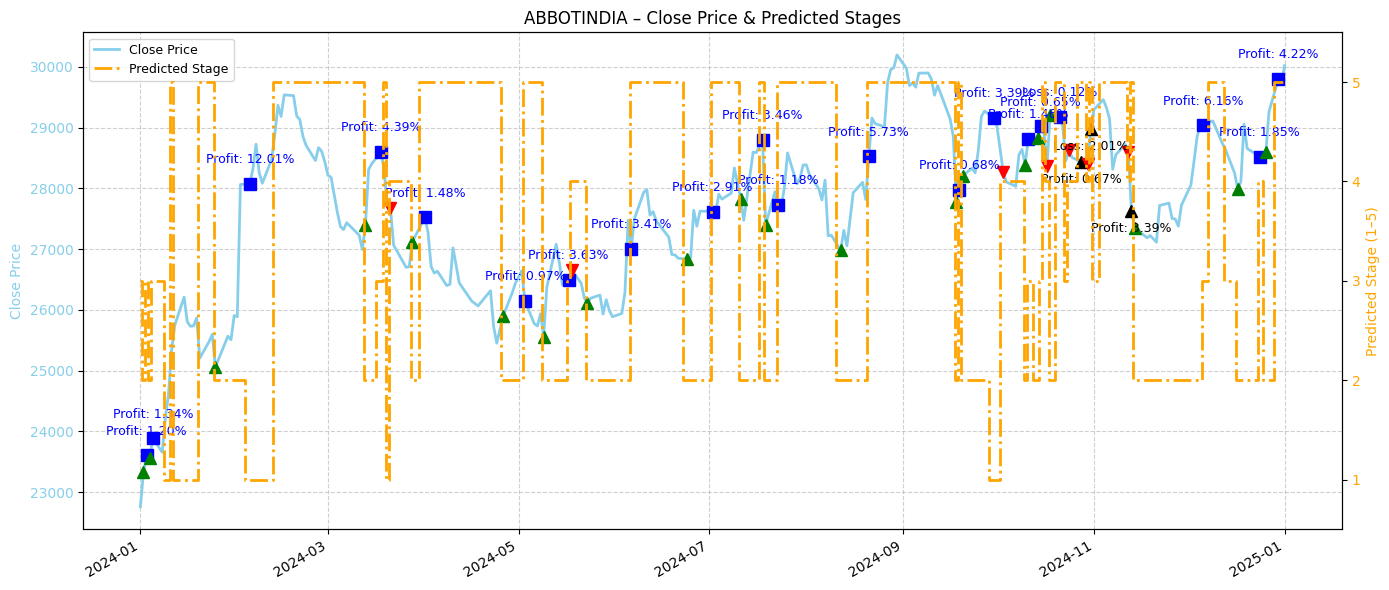

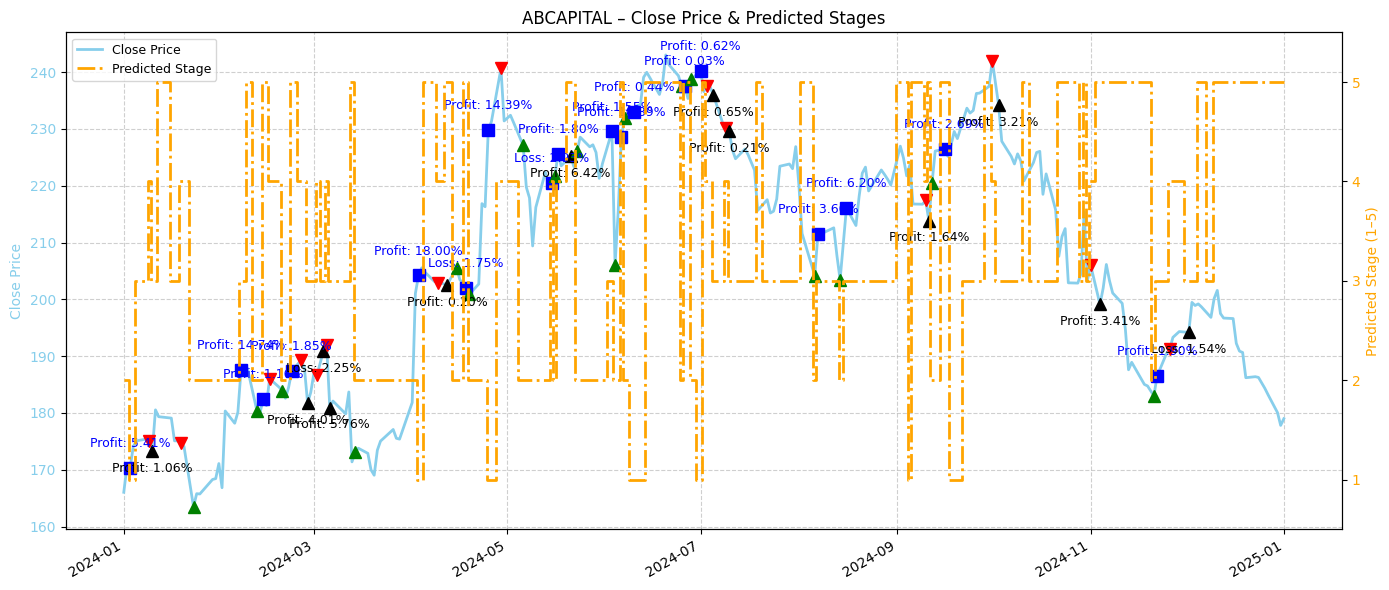

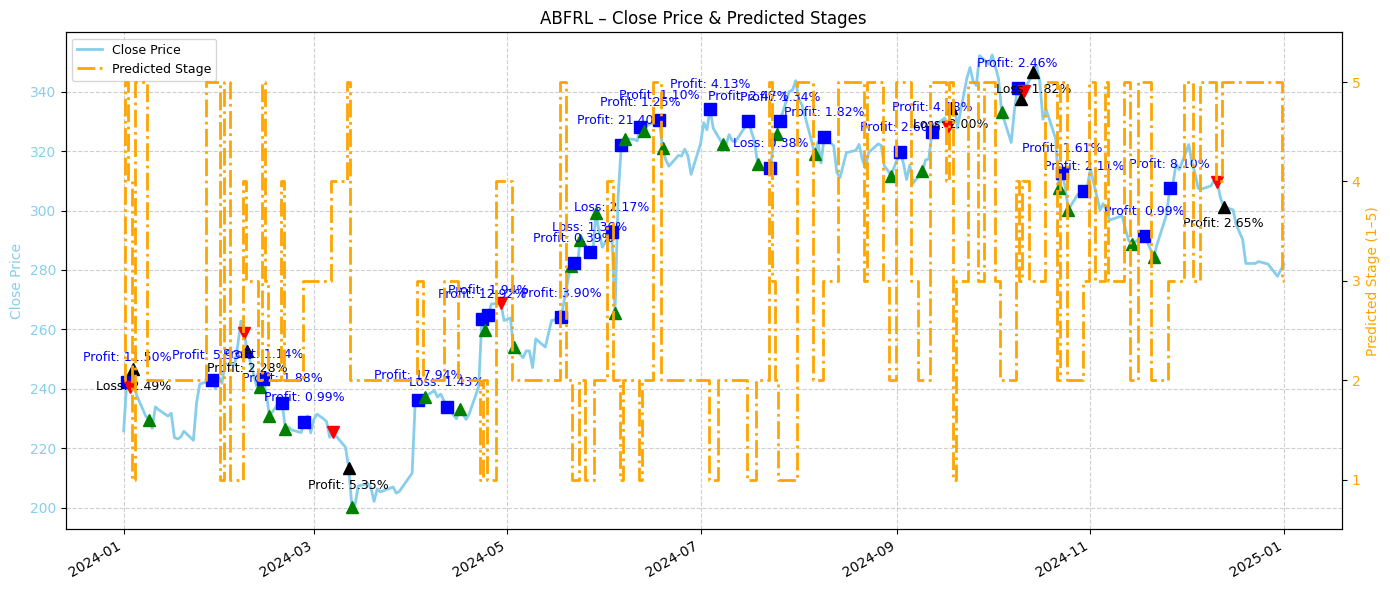

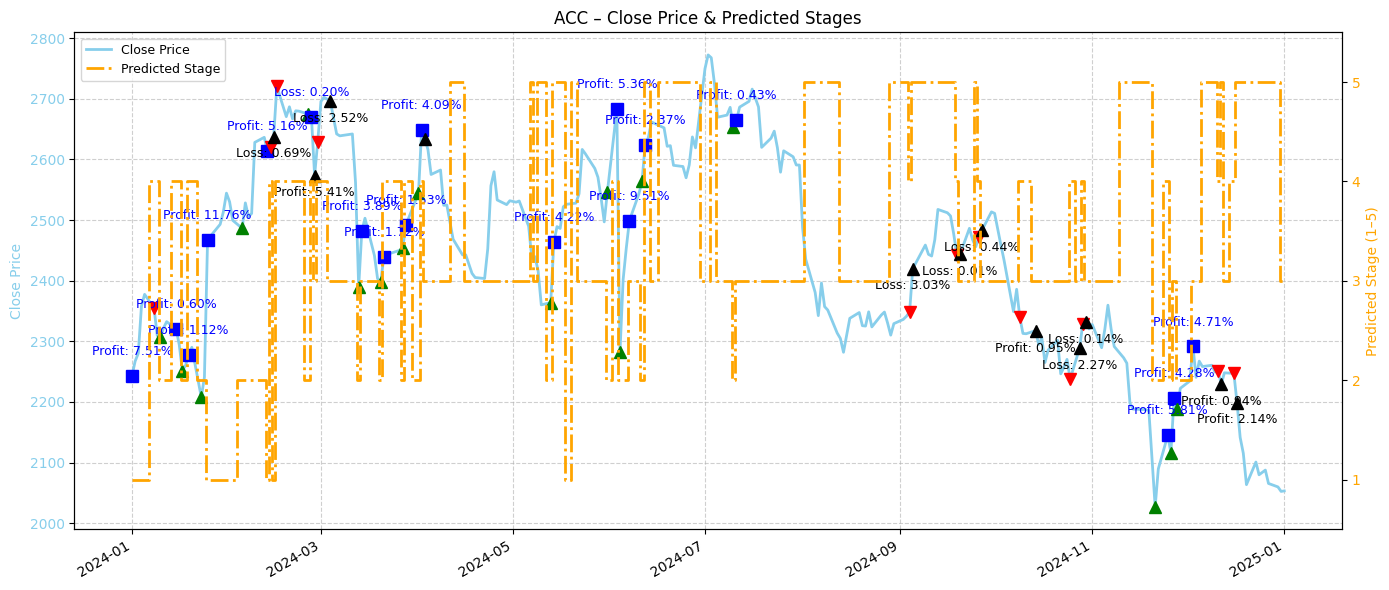

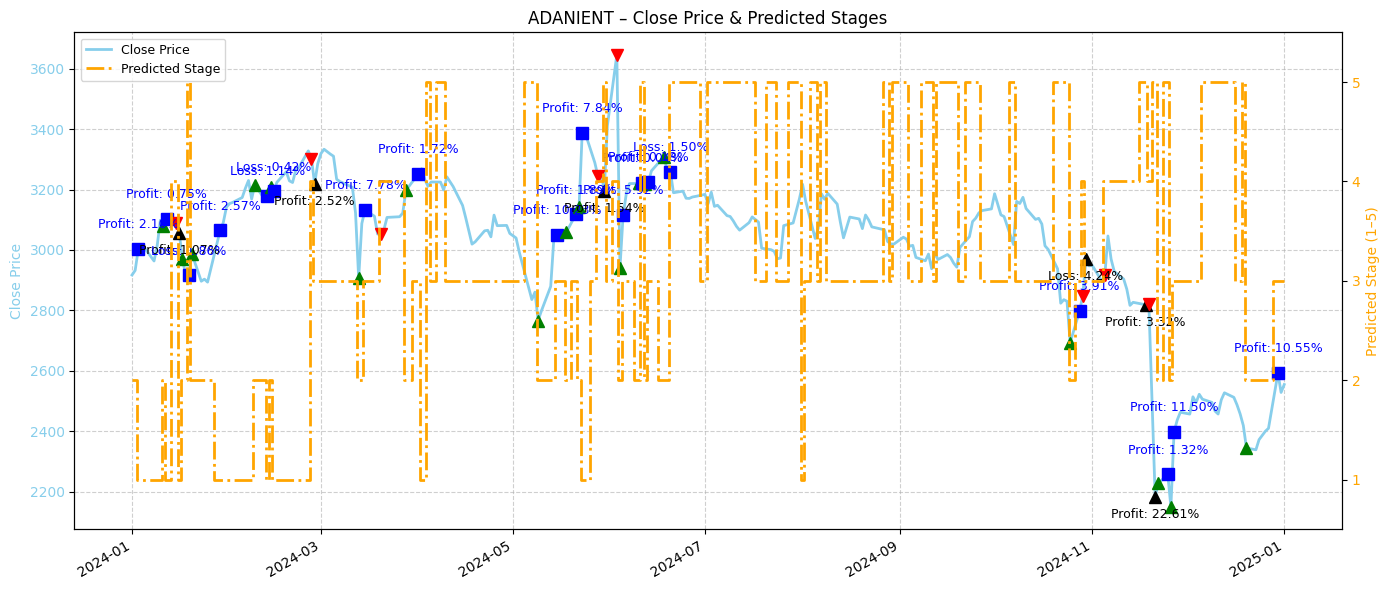

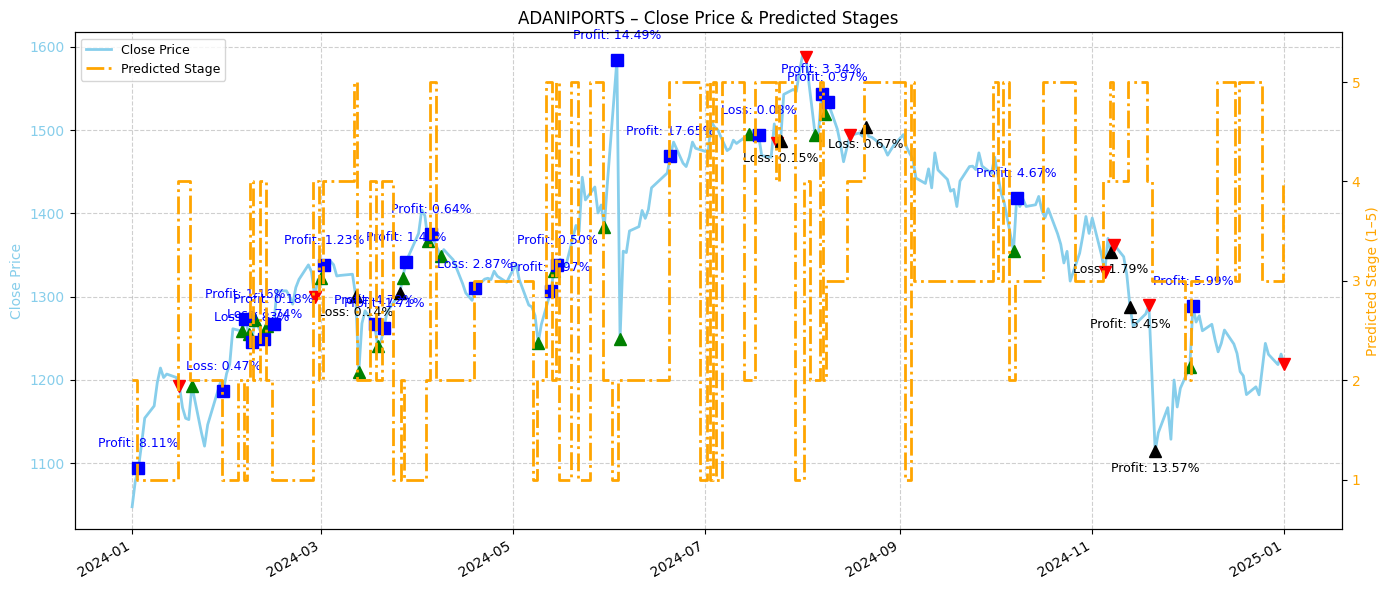

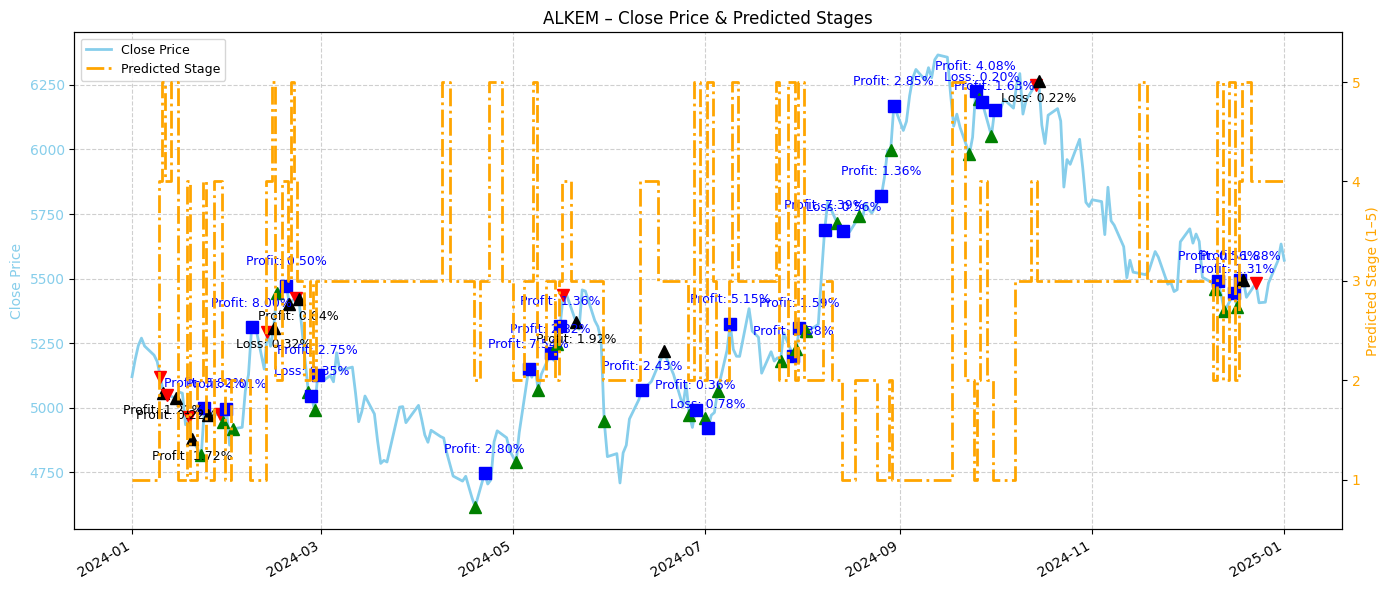

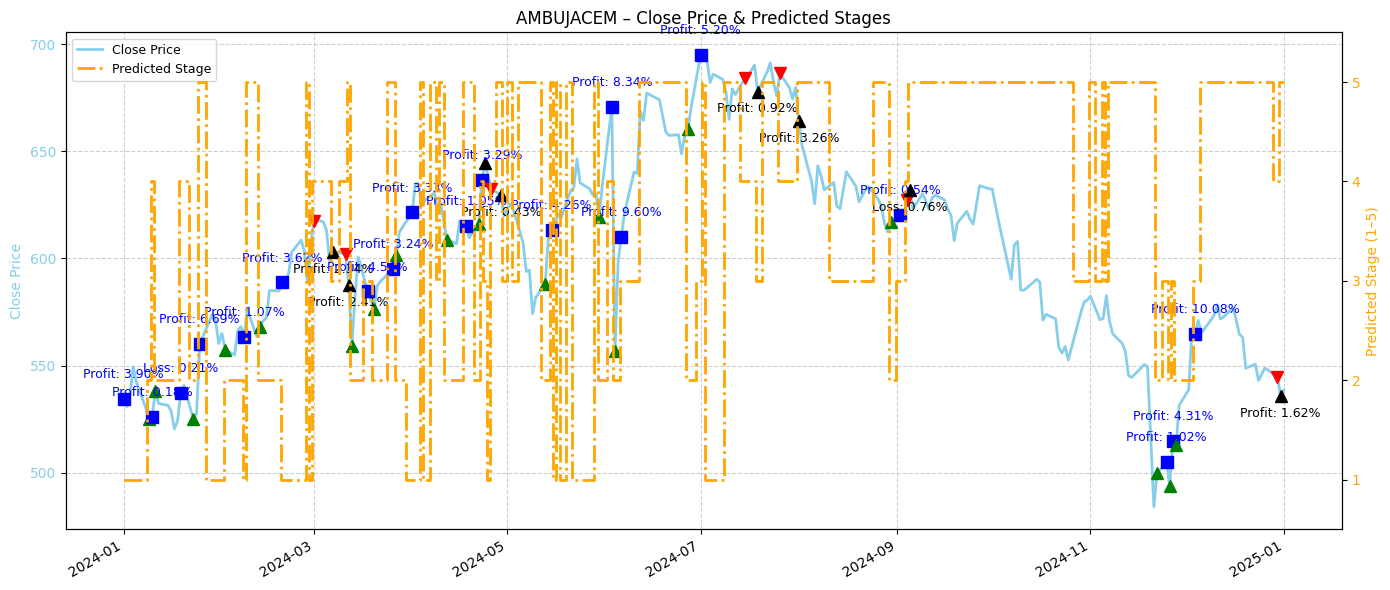

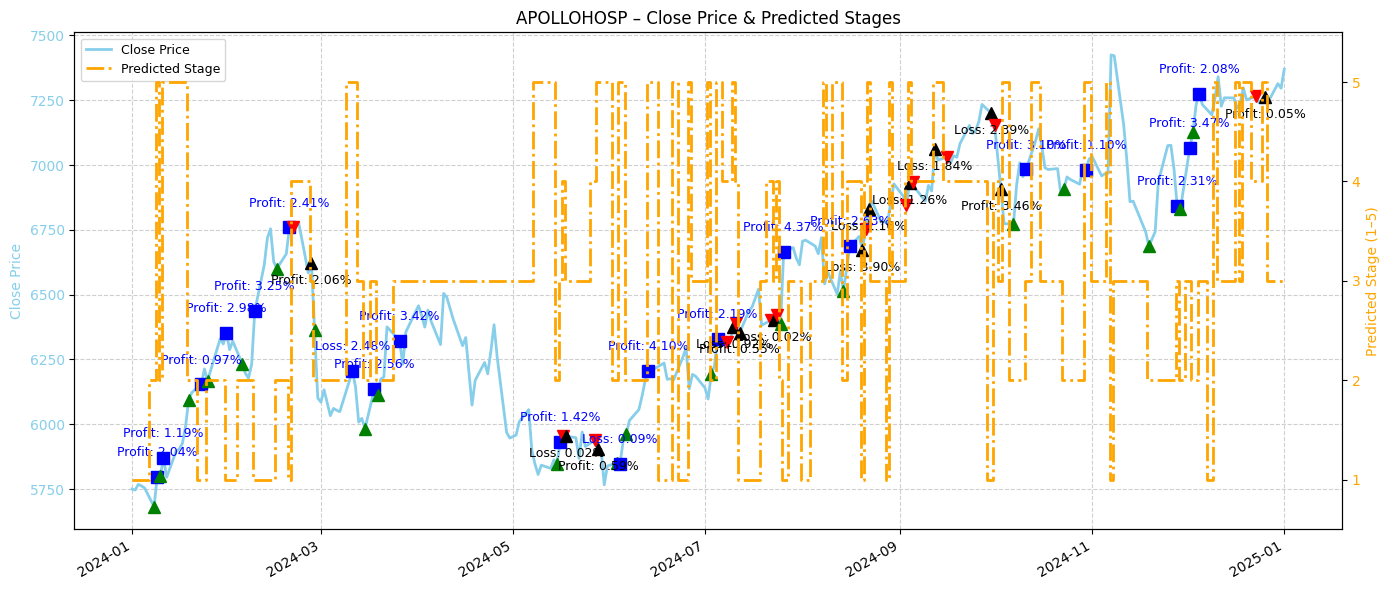

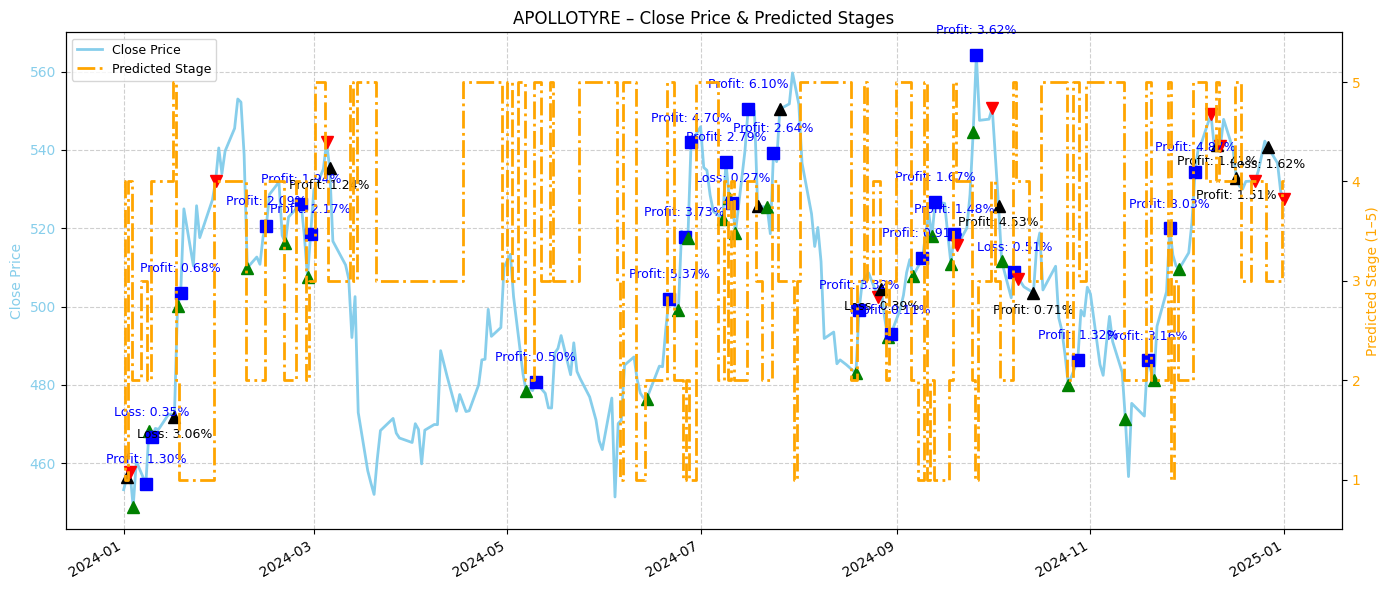

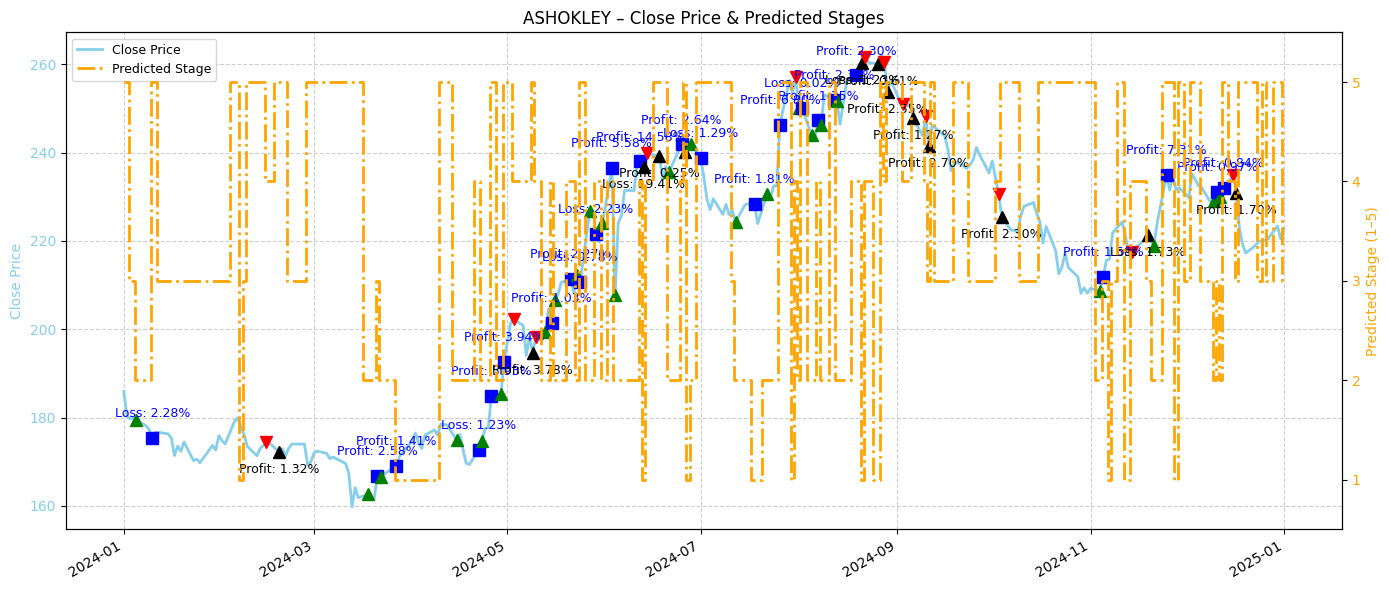

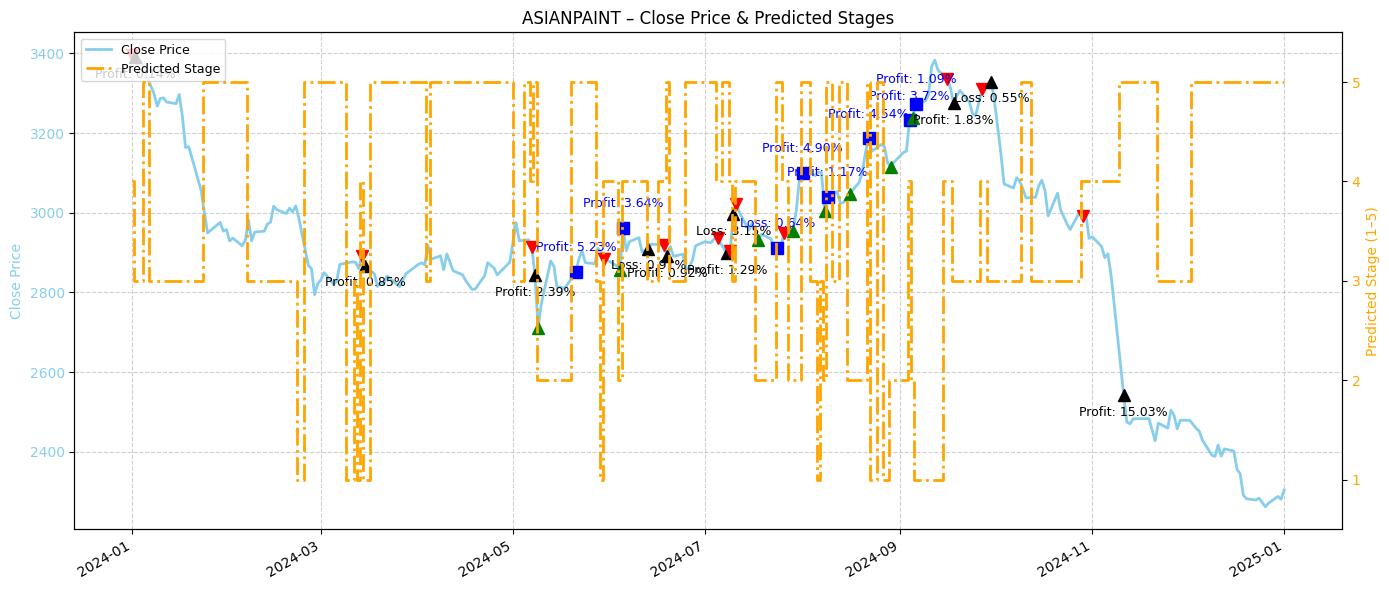

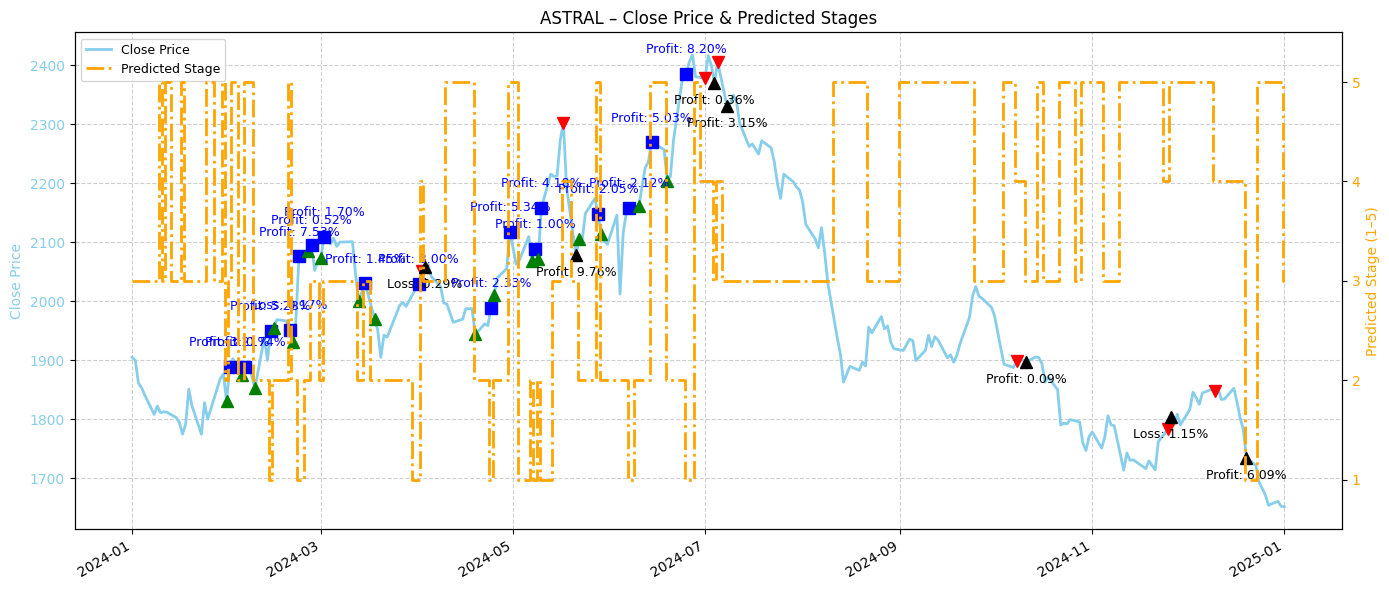

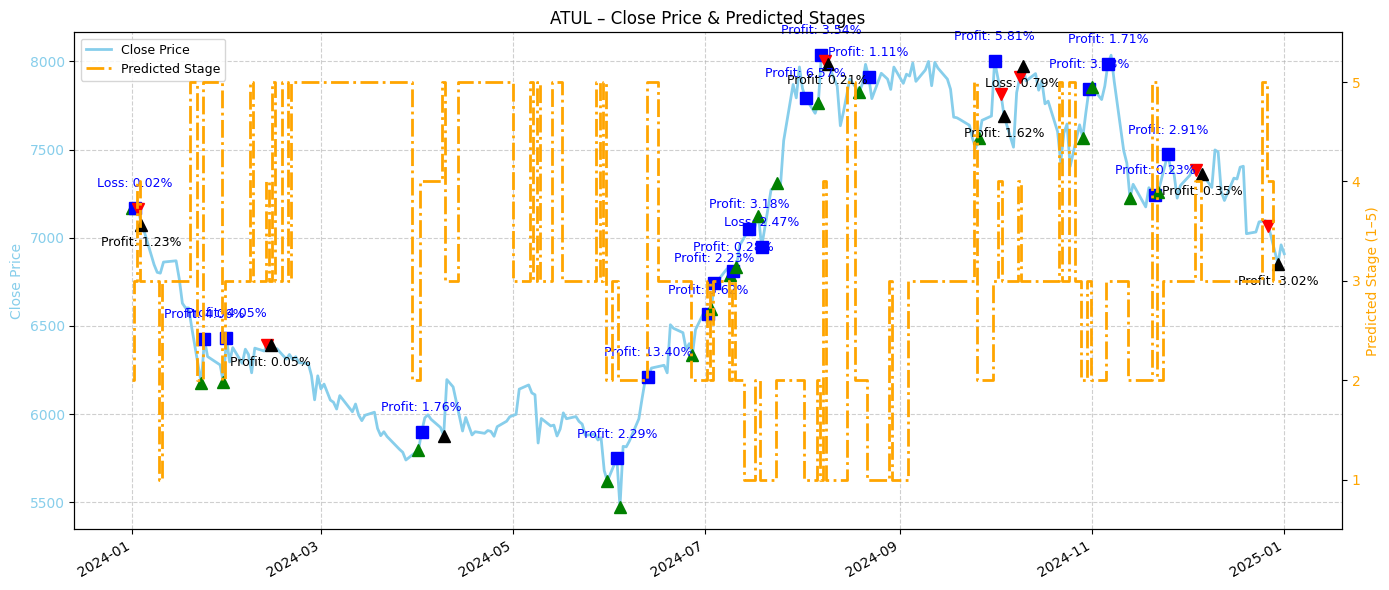

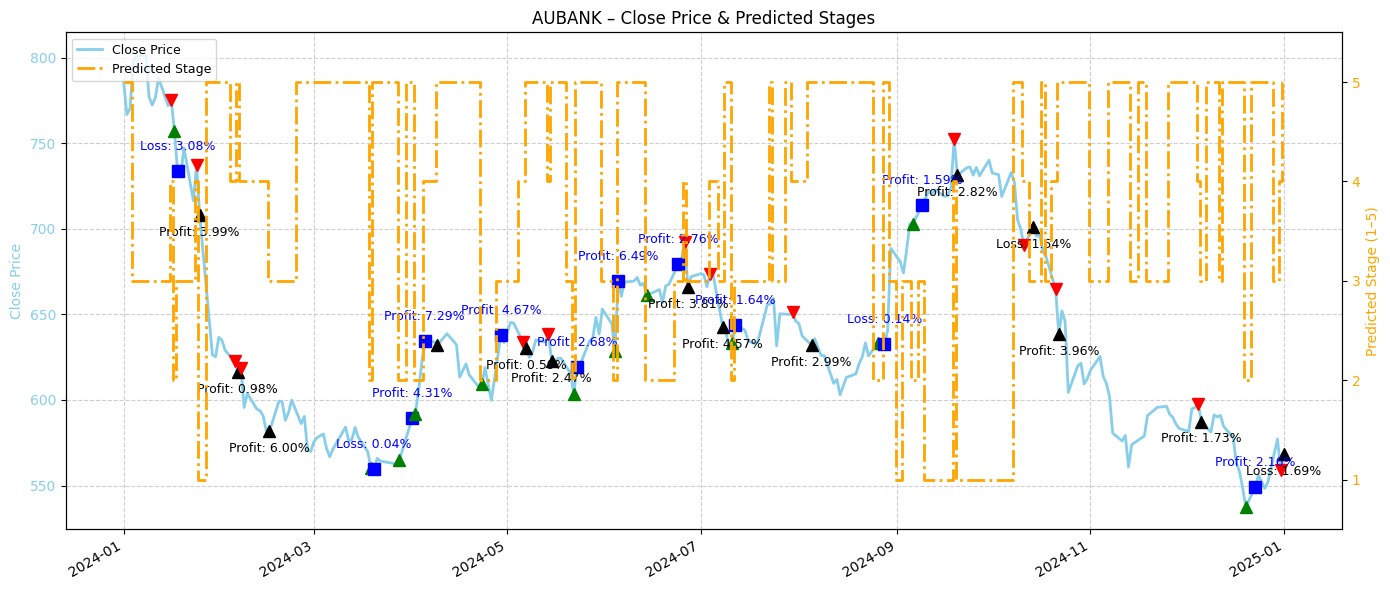

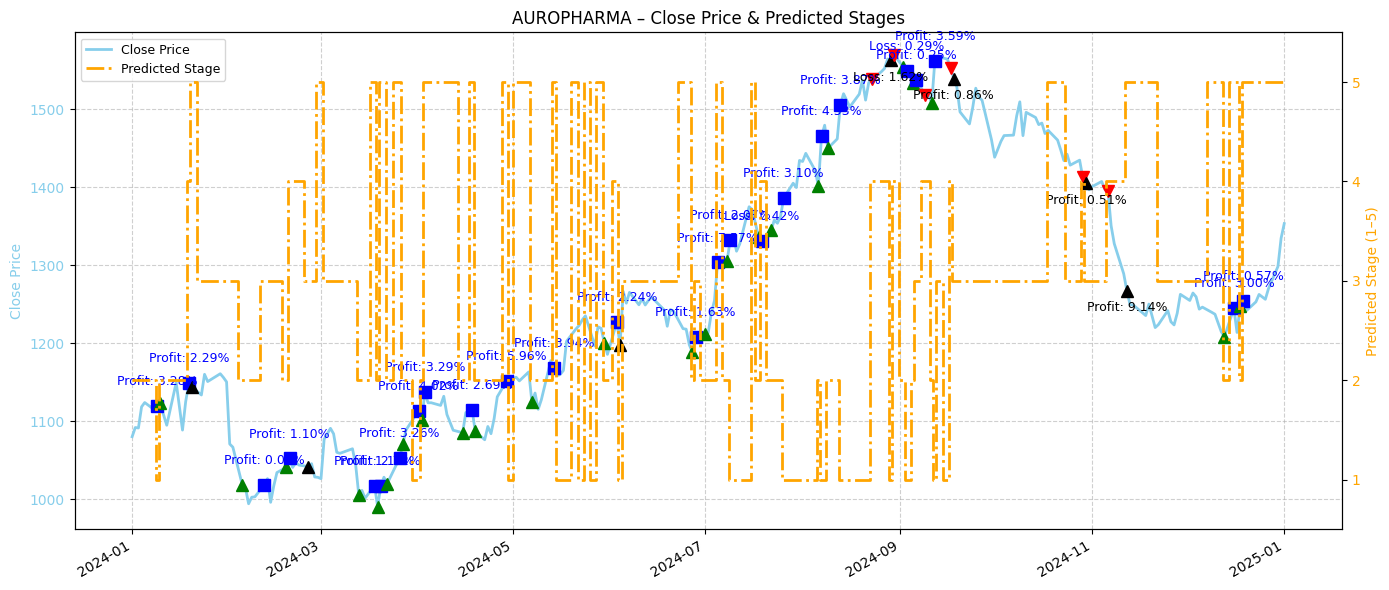

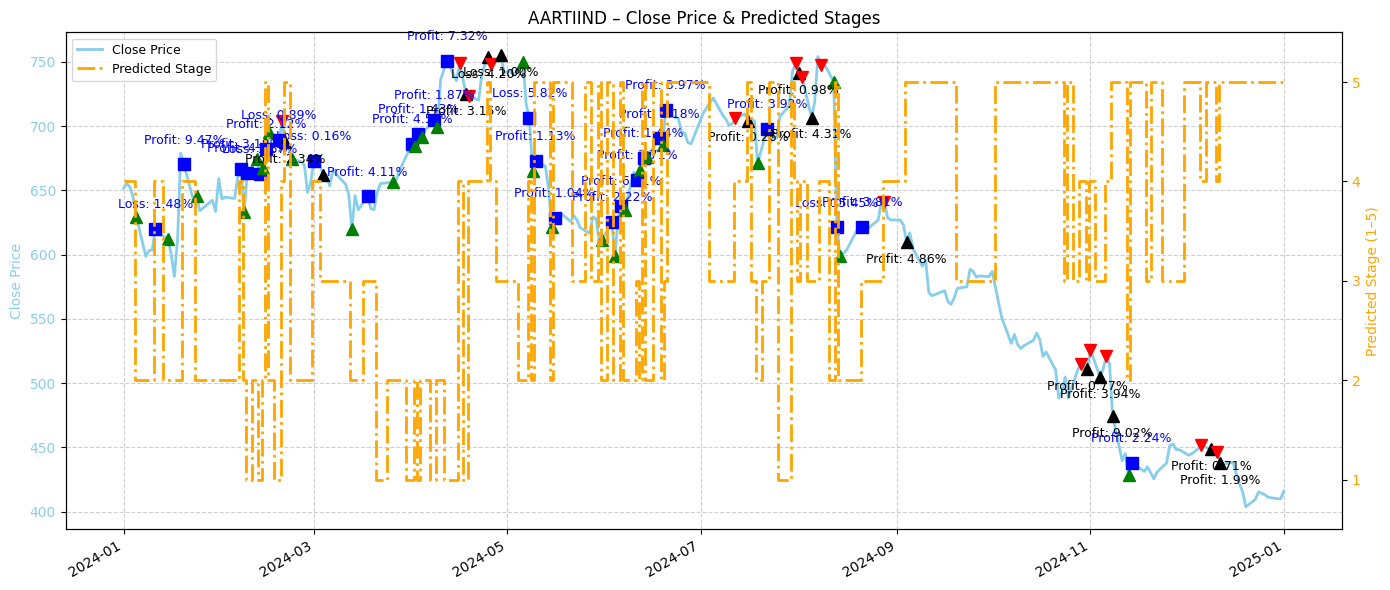

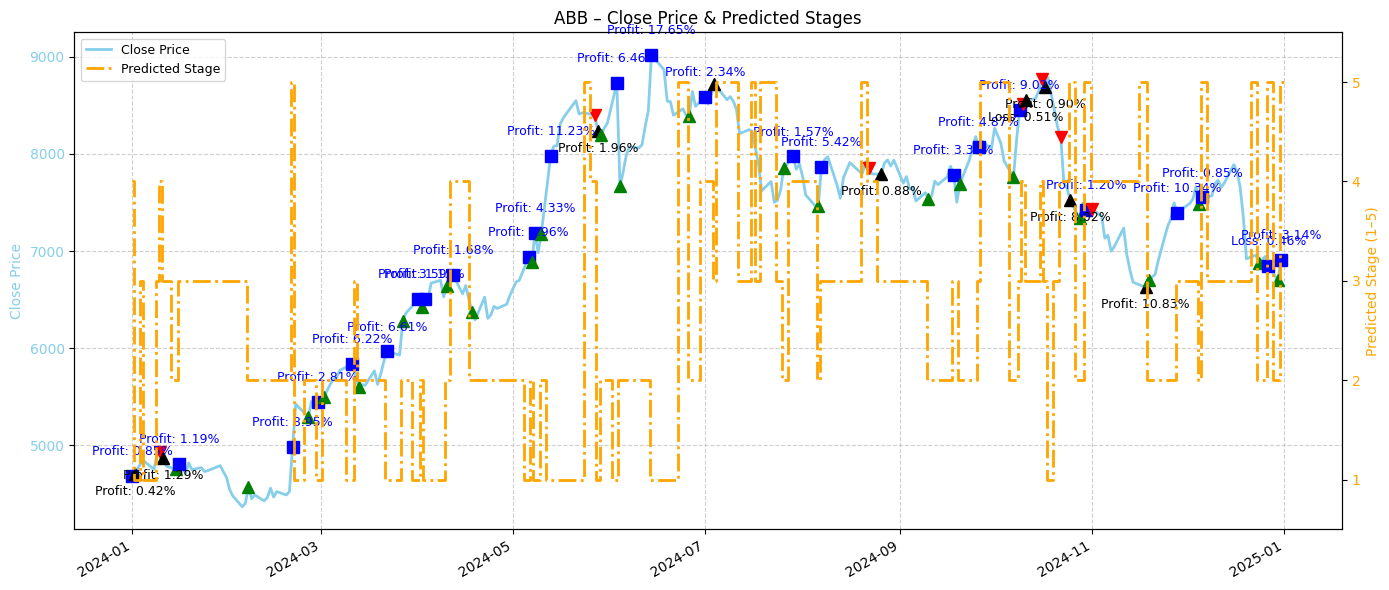

In [7]:
 # Load model
loaded = joblib.load("/content/trained_model.joblib")
scaler_loaded = loaded["scaler"]
pca_loaded = loaded["pca"]

obs_dim = pca_train.shape[1]
act_dim = 5
policy_loaded = DQN(obs_dim, act_dim)
policy_loaded.load_state_dict(loaded["model_state_dict"])
policy_loaded.eval()

# Apply model to all stocks
df_all = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
performance_records = []

for sym in df_all["TRADE_SYMBOL"].unique():
    df_sym = df_all[df_all["TRADE_SYMBOL"] == sym].reset_index(drop=True)
    if df_sym.empty: continue

    dates = df_sym["DATE"]
    closes = df_sym["CLOSE"].values.astype(float)
    raw_feats_sym = df_sym[feature_cols].values.astype(float)
    scaled_sym = scaler_loaded.transform(raw_feats_sym)
    pca_feats_sym = pca_loaded.transform(scaled_sym)

    preds = []
    with torch.no_grad():
        for x in pca_feats_sym:
            q_out = policy_loaded(torch.tensor(x, dtype=torch.float32).unsqueeze(0))
            act = int(q_out.argmax().item())
            preds.append(act + 1)

    signals = generate_trading_signal_from_stage(preds)

    proc = pd.DataFrame({
        "TRADE_SYMBOL": sym,
        "DATE": dates.values,
        "CLOSE": closes,
        "PREDICTED_STAGE": preds,
        "Trade_Signal": signals
    })

    proc["Profit_EXIT_BUY"] = np.nan
    proc["Profit_EXIT_SELL"] = np.nan

    buy_idxs = proc.index[proc["Trade_Signal"] == "BUY"]
    exit_buy_idxs = proc.index[proc["Trade_Signal"] == "EXIT_BUY"]
    short_idxs = proc.index[proc["Trade_Signal"] == "SHORT_SELL"]
    exit_sell_idxs = proc.index[proc["Trade_Signal"] == "EXIT_SELL"]

    buy_profits = []
    for b in buy_idxs:
        future = exit_buy_idxs[exit_buy_idxs > b]
        if not future.empty:
            e = future[0]
            entry = proc.loc[b, "CLOSE"]
            exit_price = proc.loc[e, "CLOSE"]
            profit = ((exit_price - entry) / entry) * 100
            proc.loc[e, "Profit_EXIT_BUY"] = profit
            buy_profits.append(profit)

    short_profits = []
    for s in short_idxs:
        future = exit_sell_idxs[exit_sell_idxs > s]
        if not future.empty:
            e = future[0]
            entry = proc.loc[s, "CLOSE"]
            exit_price = proc.loc[e, "CLOSE"]
            profit = ((entry - exit_price) / entry) * 100
            proc.loc[e, "Profit_EXIT_SELL"] = profit
            short_profits.append(profit)

    # Performance metrics
    buy_count = len(buy_profits)
    short_count = len(short_profits)
    total_buy_profit = sum(buy_profits)
    total_short_profit = sum(short_profits)
    avg_buy_profit = np.mean(buy_profits) if buy_profits else 0
    avg_short_profit = np.mean(short_profits) if short_profits else 0
    win_buy = len([p for p in buy_profits if p > 0])
    win_short = len([p for p in short_profits if p > 0])
    win_rate_buy = win_buy / buy_count * 100 if buy_count else 0
    win_rate_short = win_short / short_count * 100 if short_count else 0

    performance_records.append({
        "TRADE_SYMBOL": sym,
        "Total_BUY_Profit(%)": total_buy_profit,
        "Total_SHORT_Profit(%)": total_short_profit,
        "Total_Profit(%)": total_buy_profit + total_short_profit,
        "BUY_Trades": buy_count,
        "SHORT_Trades": short_count,
        "Avg_BUY_Profit(%)": avg_buy_profit,
        "Avg_SHORT_Profit(%)": avg_short_profit,
        "WinRate_BUY(%)": win_rate_buy,
        "WinRate_SHORT(%)": win_rate_short
    })


    mask = (proc["DATE"] >= "2024-01-01") & (proc["DATE"] <= "2025-01-01")
    proc_h1 = proc.loc[mask].reset_index(drop=True)
    logger.info(f"Plotting results for stock: {sym}")
    plot_price_and_stages(proc_h1, stage_col="PREDICTED_STAGE")

# Save performance summary
perf_df = pd.DataFrame(performance_records)
perf_df.to_csv("model_performance_by_stock.csv", index=False)
logger.info("Saved model performance metrics to model_performance_by_stock.csv")